In [1]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
using LinearAlgebra
using StaticArrays

################################################################################
# Constants
################################################################################
const R_EARTH = 6378.137  # Spherical Earth radius (km)

################################################################################
# Basic geometry helpers
################################################################################
""" Rotation matrix about the x-axis by angle θ. """
function rotX(θ)
    c = cos(θ)
    s = sin(θ)
    @SMatrix [
        1.0   0.0   0.0
        0.0    c    -s
        0.0    s     c
    ]
end

""" Rotation matrix about the y-axis by angle θ. """
function rotY(θ)
    c = cos(θ)
    s = sin(θ)
    @SMatrix [
         c   0.0    s
        0.0  1.0   0.0
        -s   0.0    c
    ]
end

"""Convert (lat, lon) in radians + radius to ECEF coordinates (x, y, z)."""
function latlon_to_ecef(lat::Float64, lon::Float64, r::Float64)
    x = r * cos(lat) * cos(lon)
    y = r * cos(lat) * sin(lon)
    z = r * sin(lat)
    return @SVector [x, y, z]
end

"""Convert ECEF (x, y, z) to spherical lat/lon in radians."""
function ecef_to_latlon(pos::SVector{3,Float64})
    x, y, z = pos
    r_xy = sqrt(x^2 + y^2)
    lat  = atan(z, r_xy)
    lon  = atan(y, x)
    return (lat, lon)
end


################################################################################
# Build local East, North, Up (ENU) axes at the sub-satellite point (lat0, lon0).
#   lat0, lon0 in radians
#   Returns (e, n, u) as normalized 3D vectors in ECEF frame.
################################################################################
function build_enu(lat0::Float64, lon0::Float64)
    # Up vector (local zenith)
    u = SVector{3}( cos(lat0)*cos(lon0),
                    cos(lat0)*sin(lon0),
                    sin(lat0) )

    # East vector
    e = SVector{3}(-sin(lon0), cos(lon0), 0.0)

    # North vector
    n = cross(u, e)  # or cross(e, u), depending on sign convention
    return (e, n, u)
end

################################################################################
# Main function: given:
#   lat0, lon0: sub-satellite lat/lon in radians
#   h: satellite altitude above Earth (km)
#   pitch, roll: angles in radians
#
# Returns:
#   dLat, dLon - the difference (in degrees) from (lat0, lon0) to the target
#                intersection point on Earth’s surface
################################################################################
function relative_latlon_offset(
        lat0::Float64,
        lon0::Float64,
        h::Float64,
        pitch::Float64,
        roll::Float64;
        R::Float64 = R_EARTH
    )

    # 1) Satellite position in ECEF:
    r_satellite = R + h
    sat_ecef = latlon_to_ecef(lat0, lon0, r_satellite)

    # 2) Local ENU axes at sub-satellite point:
    ê, n̂, û = build_enu(lat0, lon0)

    # 3) Define the nadir direction in local coordinates.
    #    In our local ENU, the “down” (nadir) direction is -û.
    #    We'll store it as a 3×1 vector: v_local = [0, 0, -1] is simpler
    #    but we need to align with the actual ENU basis if applying rotation
    #    in that local coordinate frame.
    # 
    #    We'll do this:
    #      - start with the local-vector [0,0,-1],
    #      - apply roll about x, then pitch about y,
    #      - then map it into ECEF.
    #
    #    So the local tangent coordinate system is X = ê, Y = n̂, Z = û.
    #    v_local = (0, 0, -1).
    #
    v_local_nadir = SVector{3}(0.0, 0.0, -1.0)

    # 4) Build the total rotation in local coordinates:
    #    roll about x => Rx(roll)
    #    pitch about y => Ry(pitch)
    #    final local vector = Ry(pitch)*Rx(roll)*v_local_nadir
    #
    #    (You might swap the order of rotations if your pitch/roll definitions
    #     differ from the convention used here.)
    #
    v_local = rotY(pitch) * (rotX(roll) * v_local_nadir)

    # 5) Convert this local vector into ECEF by linear combination of (ê, n̂, û):
    #    v_ecef = v_local[1]*ê + v_local[2]*n̂ + v_local[3]*û
    #
    v_ecef = v_local[1]*ê + v_local[2]*n̂ + v_local[3]*û

    # 6) Solve for intersection of ray with Earth (sphere of radius R):
    #    We have parametric line:
    #      X(t) = sat_ecef + t * v_ecef
    #    We want norm(X(t)) = R
    #
    #    => ||sat_ecef + t v_ecef||^2 = R^2
    #    => let S = sat_ecef, V = v_ecef:
    #       (S + tV)·(S + tV) = R^2
    #       S·S + 2t(S·V) + t^2 (V·V) = R^2
    #    Solve for t and pick the smaller positive root (the intersection “below” the satellite).
    #
    S = sat_ecef
    V = v_ecef
    S_dot_S = dot(S,S)
    S_dot_V = dot(S,V)
    V_dot_V = dot(V,V)

    # Quadratic: a*t^2 + b*t + c = 0
    a = V_dot_V
    b = 2.0 * S_dot_V
    c = S_dot_S - R^2

    # Solve:
    discriminant = b^2 - 4*a*c
    if discriminant < 0
        error("No real intersection found (discriminant < 0). Check geometry.")
    end

    t1 = (-b + sqrt(discriminant)) / (2a)
    t2 = (-b - sqrt(discriminant)) / (2a)

    # We want the intersection *in front* of the satellite along v_ecef
    # Typically t will be negative if the direction is 'down' toward Earth,
    # but it depends how you define v_ecef.  Check which root is physically correct.
    #
    # Generally, one root will be between 0 and 1*(some range),
    # or might be negative. Evaluate both and pick whichever is valid and is closer to the satellite.
    #
    # Because v_local_nadir = (0,0,-1), the direction is indeed “down.”
    # But let's just pick the smaller positive solution or the larger negative solution
    # depending on sign conventions. In many setups, the correct intersection is
    # the *larger* negative t if v is downward. You can test & pick the one that
    # yields a smaller ||X - S|| in magnitude. We'll do a simple check here:
    #
    candidates = [t1, t2]
    # pick the one that yields the smaller distance from sat_ecef to the Earth:
    function distance_to_sat(t) 
        return norm(S + t*V - S) 
    end
    t_candidates = filter(t -> !isnan(t), candidates)
    if isempty(t_candidates)
        error("No valid intersection parameter found.")
    end
    t_best = t_candidates[argmin(distance_to_sat.(t_candidates))]

    # Intersection point on Earth:
    X_int = S + t_best * V

    # 7) Convert intersection ECEF -> lat/lon (in radians):
    (lat_int, lon_int) = ecef_to_latlon(X_int)

    # 8) Return the difference (in degrees) from the sub-satellite point
    dLat = (lat_int - lat0) * (180/pi)
    dLon = (lon_int - lon0) * (180/pi)

    return dLat, dLon
end


################################################################################
# Example usage
################################################################################

# Suppose the sub-satellite point is at latitude=10°, longitude=45°,
# altitude = 700 km, with pitch=2°, roll=-1° (all angles in degrees).
# Let's compute the relative lat/lon shift (in degrees).
#



  Activating project at `~/code/gitHub/CarbonI`


relative_latlon_offset (generic function with 1 method)

In [2]:
function example()
    lat0_deg  = 10.0
    lon0_deg  = 45.0
    alt_km    = 668.0
    pitch_deg = 30.0
    roll_deg  = 25.0

    # Convert input angles to radians for internal trigonometry:
    deg2rad = π/180
    lat0  = lat0_deg * deg2rad
    lon0  = lon0_deg * deg2rad
    pitch = pitch_deg * deg2rad
    roll  = roll_deg * deg2rad

    ifov = 51.7/1000000

    dLat, dLon = relative_latlon_offset(lat0, lon0, alt_km, pitch, roll)
    dLatIFOV, dLonIFOV = relative_latlon_offset(lat0, lon0, alt_km, pitch+ifov, roll+ifov)
    println("Relative offset in latitude = $dLat degrees")
    println("Relative offset in longitude = $dLon degrees")

    ΔLat = abs(dLat - dLatIFOV)*deg2rad*R_EARTH*1000
    ΔLon = abs(dLon - dLonIFOV)*deg2rad*R_EARTH*1000
    println("Footprint across track= $ΔLat m")
    println("Footprint along track = $ΔLon m")
end

example()

Relative offset in latitude = 3.3260781424949233 degrees
Relative offset in longitude = -3.687660466643002 degrees
Footprint across track= 64.69722898906602 m
Footprint along track = 54.273577211282735 m


In [3]:
pitch_deg = 0:38.0
roll_deg  = 0.0
lat0_deg  = 10.0
lon0_deg  = 45.0
alt_km    = 668.0
# Convert input angles to radians for internal trigonometry:
deg2rad = π/180
lat0  = lat0_deg * deg2rad
lon0  = lon0_deg * deg2rad
pitch = pitch_deg * deg2rad
roll  = roll_deg * deg2rad

ifov = 51.7/1e6;

In [4]:
function computeAcrossTrackSize(roll_deg)
    roll = roll_deg * deg2rad
    dGeo = relative_latlon_offset.(lat0, lon0, alt_km, pitch, roll)
    dGeoIFOV = relative_latlon_offset.(lat0, lon0, alt_km, pitch .+ifov, roll .+ifov)

    dLats = [a[1] for a in dGeo];
    ddLats = [a[1] for a in dGeoIFOV];

    dLons = [a[2] for a in dGeo];
    ddLons = [a[2] for a in dGeoIFOV];

    dAcross = abs.(dLats.-ddLats)*deg2rad*R_EARTH*1000
    dAlong  = abs.(dLons.-ddLons)*deg2rad*R_EARTH*1000
    return dAcross, dAlong
end

computeAcrossTrackSize (generic function with 1 method)

In [5]:
computeAcrossTrackSize(20.0)

([39.975159765677844, 40.21881544152389, 40.47697370605183, 40.75010924077659, 41.038728807527406, 41.34337377110653, 41.66462283496665, 42.003095018925954, 42.359452913921324, 42.734406244993664  …  55.8932235523033, 56.97508452679329, 58.11901240013857, 59.329836224459946, 60.61293356613309, 61.97431214725672, 63.420706897144754, 64.95969599912317, 66.59984050198139, 68.35085340113287], [35.582377415381416, 35.639137393971495, 35.72209303102786, 35.83148136678593, 35.967624558371845, 36.130932110377195, 36.32190376748111, 36.54113309612854, 36.78931181468477, 37.06723492787311  …  51.44893829469652, 52.84581403814476, 54.34687166380473, 55.9615047855714, 57.70031805401354, 59.57532266590482, 61.6001712897961, 63.79044202931533, 66.16398382135539, 68.74133938383116])

In [6]:
using CairoMakie
include(joinpath("../../src/Plots", "CI_colorsNew.jl"));
set_theme!(theme_ggplot2())

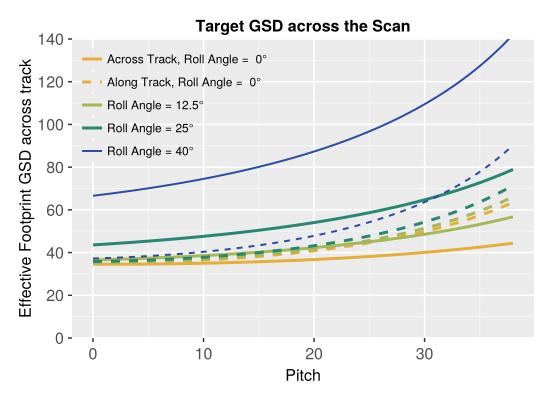

In [7]:

f = Figure(resolution=(550,400))
lowerLim = 4.0

ax = Axis(f[1,1], xlabel="Pitch", ylabel="Effective Footprint GSD across track",  title="Target GSD across the Scan")
lines!(ax, pitch_deg , computeAcrossTrackSize(0.0)[1], color=CarbonI_colors[1], linewidth=3,  label="Across Track, Roll Angle =  0°")
lines!(ax, pitch_deg , computeAcrossTrackSize(0.0)[2], color=CarbonI_colors[1], linewidth=3, linestyle=:dash,  label="Along Track, Roll Angle =  0°")
lines!(ax, pitch_deg , computeAcrossTrackSize(12.5)[1], color=CarbonI_colors[2], linewidth=3, label="Roll Angle = 12.5°")
lines!(ax, pitch_deg , computeAcrossTrackSize(12.5)[2], color=CarbonI_colors[2], linewidth=3, linestyle=:dash)
lines!(ax, pitch_deg , computeAcrossTrackSize(25.0)[1], color=CarbonI_colors[3], linewidth=3,  label="Roll Angle = 25°")
lines!(ax, pitch_deg , computeAcrossTrackSize(25.0)[2], color=CarbonI_colors[3], linewidth=3, linestyle=:dash)
lines!(ax, pitch_deg , computeAcrossTrackSize(40.0)[1], color=CarbonI_colors[4], linewidth=2, label="Roll Angle = 40°")
lines!(ax, pitch_deg , computeAcrossTrackSize(40.0)[2], color=CarbonI_colors[4], linewidth=2,linestyle=:dash)
#lines!(ax, pitch_deg , computeAcrossTrackSize(0.0), color=CarbonI_colors[5], linewidth=2, label="Roll Angle = 45°")

axislegend(ax,position = :lt;  labelsize=12)
ylims!(ax, 0, 140)
f


In [10]:
using Statistics
mean_xTrack_GSD = median([computeAcrossTrackSize(0.0)[1]; computeAcrossTrackSize(15)[1] ; computeAcrossTrackSize(30.0)[1]]);
@show mean_xTrack_GSD/34.5

mean_xTrack_GSD / 34.5 = 1.276498222474514


1.276498222474514